In [1]:
## Importing Dependencies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics import roc_auc_score, accuracy_score, auc, roc_curve, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
import yellowbrick
from yellowbrick.classifier import ROCAUC

%matplotlib inline
plt.style.use('ggplot')

D:\WorkArea\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df = pd.read_csv('Churn_Modelling.csv', low_memory=False)

In [3]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
df.info() ## seems like no missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


## Data Analysis and Exploration

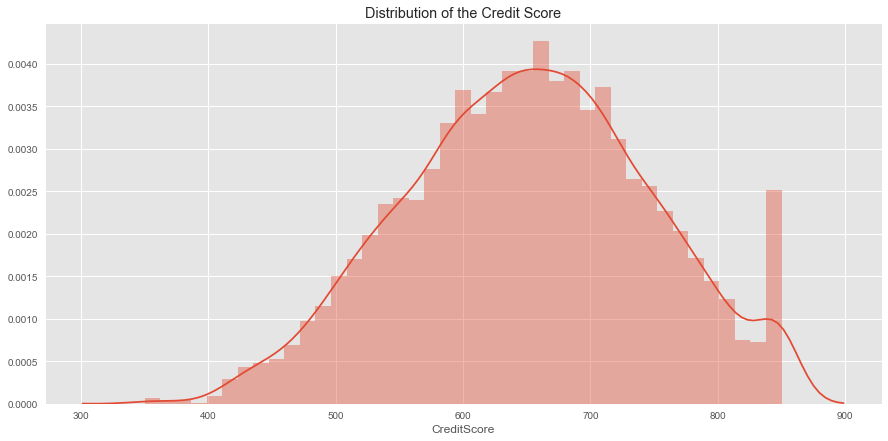

In [5]:
plt.figure(figsize=(15,7))
sns.distplot(df['CreditScore'])
plt.title('Distribution of the Credit Score')
plt.show()

## Almost a Normal Distribution

In [6]:
## Logistic regression with just the the credit score and the Target
X = df[['CreditScore']]
y = df['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 25)
clr = LogisticRegression()

clr.fit(X_train, y_train)
clr.predict(X_test)

print("Accuracy of the model: {}".format(accuracy_score(y_test, clr.predict(X_test))))
print("10-fold cross validation accuracy of the model: {}".format(cross_val_score(clr,X_train, y_train, cv=10).mean()))

## We are able to get pretty good accuracy with just the credit scores

Accuracy of the model: 0.8068
10-fold cross validation accuracy of the model: 0.792800416237777


In [7]:
roc_auc_score(y_test, clr.predict(X_test)) ## Really bad

0.5

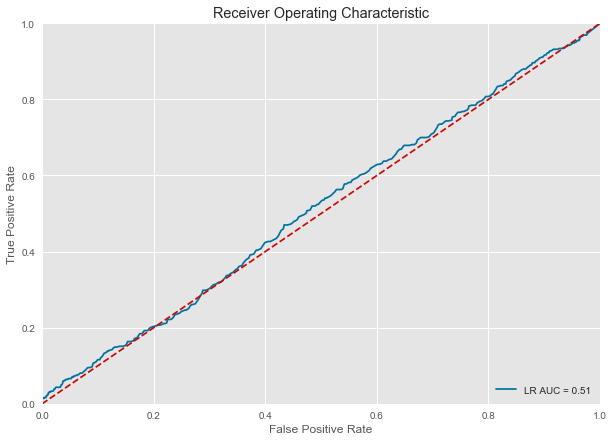

In [8]:
plt.figure(figsize=(10,7))
probs = clr.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'LR AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

### Lets continue and see what we discover that can improve the model

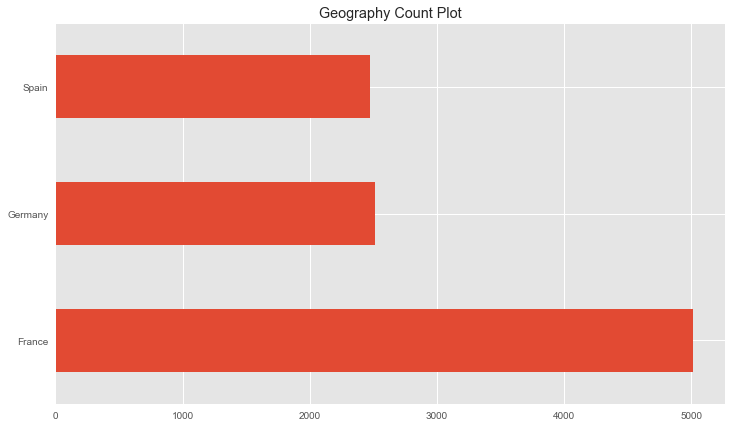

In [9]:
plt.figure(figsize=(12,7))
plt.title('Geography Count Plot')
df['Geography'].value_counts().plot(kind='barh')

## Half the dataset is france

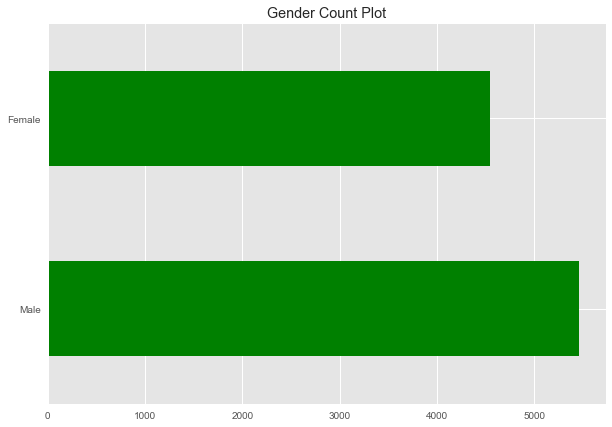

In [10]:
plt.figure(figsize=(10,7))
plt.title('Gender Count Plot')
df['Gender'].value_counts().plot(kind='barh', color='green')

## Almost balanced

In [11]:
## Question to answer how many are from france and have excited?

for i in df['Geography'].unique():
    print(i)
    print(20 * '--')
    print(len(df[(df['Geography'] == i)]))
    print(len(df[(df['Geography'] == i) & (df['Exited'] == 1)]) / len(df[(df['Geography'] == i)]))
    print('\n')

## We can see that in Germany about 1/3 of the people exited

France
----------------------------------------
5014
0.16154766653370561


Spain
----------------------------------------
2477
0.1667339523617279


Germany
----------------------------------------
2509
0.32443204463929853




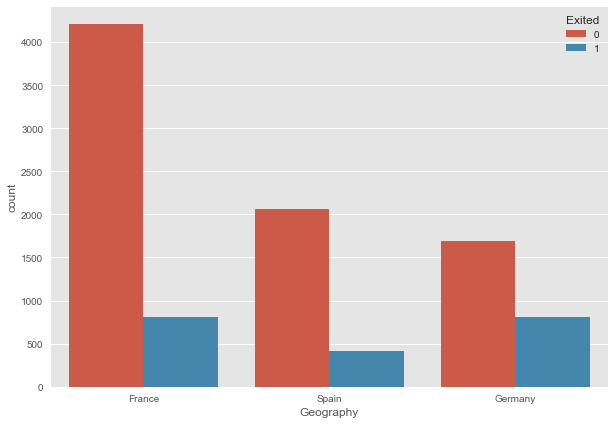

In [12]:
plt.figure(figsize=(10,7))
sns.countplot(df['Geography'], hue=df['Exited'])

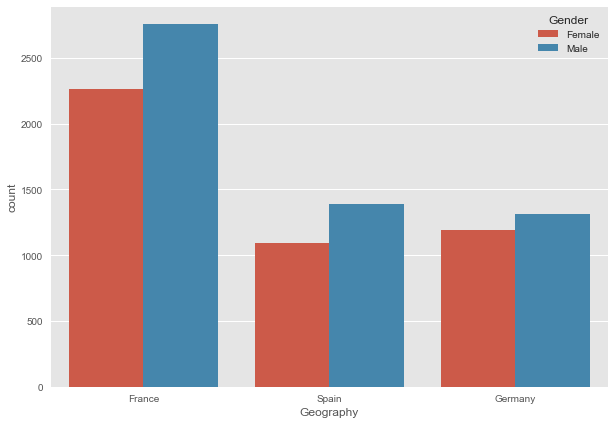

In [13]:
plt.figure(figsize=(10,7))
sns.countplot(df['Geography'], hue=df['Gender'])

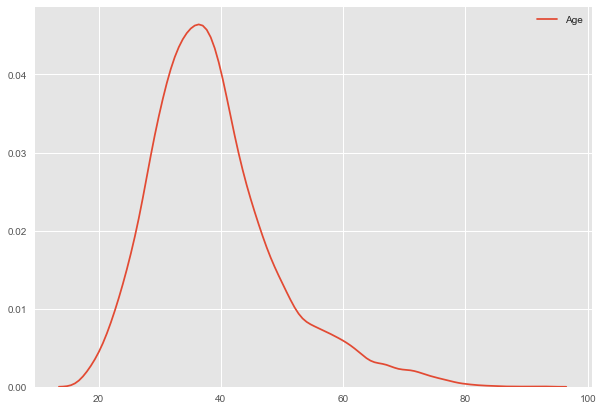

In [14]:
plt.figure(figsize=(10,7))
sns.kdeplot(df['Age'])

## Again almost a normal distribution!

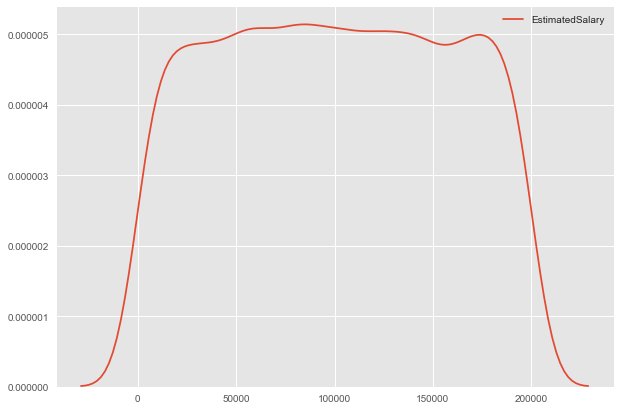

In [15]:
plt.figure(figsize=(10,7))
sns.kdeplot(df['EstimatedSalary'])

In [16]:
df['Tenure'].describe()

count    10000.000000
mean         5.012800
std          2.892174
min          0.000000
25%          3.000000
50%          5.000000
75%          7.000000
max         10.000000
Name: Tenure, dtype: float64

In [17]:
## Lets look at that turn out the be important features

In [18]:
rfe = RFE(RandomForestClassifier(n_estimators=1000), n_features_to_select=5)

In [19]:
X = df.iloc[:,3:-1]
y = df['Exited']

## Encode the categorical variables
X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 25)

In [20]:
rfe.fit(X_train,y_train)

RFE(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
  n_features_to_select=5, step=1, verbose=0)

In [21]:
rfe.ranking_

array([1, 1, 2, 1, 1, 6, 3, 1, 4, 7, 5])

In [22]:
rfe.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [23]:
roc_auc_score(y_test, rfe.predict(X_test)) ## Slightly better

0.67290350858284287

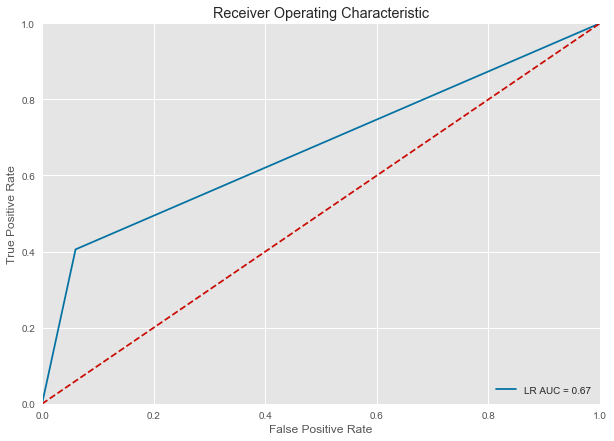

In [24]:
plt.figure(figsize=(10,7))
probs = rfe.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, rfe.predict(X_test))
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'LR AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [25]:
rf = RandomForestClassifier(n_estimators=1000)

In [26]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [27]:
rf.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [28]:
roc_auc_score(y_test, rf.predict(X_test))

0.71192175001103453

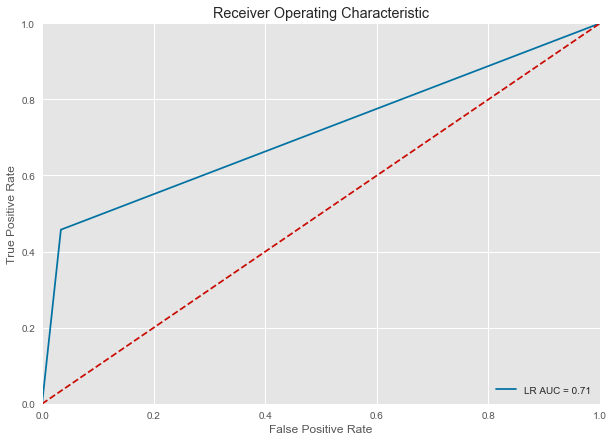

In [29]:
plt.figure(figsize=(10,7))
probs = rfe.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, rf.predict(X_test))
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'LR AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [30]:
for i , j in zip(rf.feature_importances_, X.columns):
    print(j,i)

CreditScore 0.142376738965
Age 0.241170482945
Tenure 0.0811831909984
Balance 0.140205537828
NumOfProducts 0.131425657517
HasCrCard 0.0187316121858
IsActiveMember 0.0398156004091
EstimatedSalary 0.14419385219
Geography_Germany 0.0277415521433
Geography_Spain 0.0142899275729
Gender_Male 0.0188658472451


In [31]:
rfe.ranking_

array([1, 1, 2, 1, 1, 6, 3, 1, 4, 7, 5])

In [32]:
## Okay good!

## Lets use Random Forest and build further, lets also look at the other metrics and see how the rf is doing

In [33]:
y_pred = rf.predict(X_test)

In [34]:
print("Accuracy of the model: {}".format(accuracy_score(y_test, y_pred)))
print("10-fold cross validation accuracy of the model: {}".format(cross_val_score(clr,X_train, y_train, cv=10).mean()))

Accuracy of the model: 0.868
10-fold cross validation accuracy of the model: 0.7850651152565012


In [35]:
confusion_matrix(y_test, y_pred)

array([[1949,   68],
       [ 262,  221]], dtype=int64)

In [36]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.88      0.97      0.92      2017
          1       0.76      0.46      0.57       483

avg / total       0.86      0.87      0.85      2500



In [37]:
## Ends here!!